# Sentiment Analysis of E-Commerce Review Data

- Sentiment analysis based on reviews
  - The outcome variable is labeled as "recommend" or "not recommend"
- The analysis contains Natural Language Processing
  - Stemming
  - Lemmatizing
  - TF-IDF
- Classification
  - Logistic regression
  - Suppor Vector Machine
  - Naive Bayes 
- Performance metric
  - AUC

In [47]:
!pip install imblearn

# 1. Load and Explore the Dataset

In [48]:
# Import libraries

# Data handling
import pandas as pd
import numpy as np

# NLP
## Stopwords and Stemming
import re, nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
## Lemmatization
from nltk.stem import WordNetLemmatizer
import re
# TF-IDF vectors
from sklearn.feature_extraction.text import TfidfVectorizer

# Data preparation
## Splitting train and test
from sklearn.model_selection import train_test_split
## Combining SMOTE and Edited Nearest Neighbors sampling for imbalanced classification
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours

# Classification
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

# Model performance
## Performance metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
## ROC curve
from sklearn.metrics import roc_curve,auc
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
# Set file path
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [10]:
# Load the dataset
df = pd.read_csv("/Users/mmikaela/Downloads/Clothing_data.csv", encoding="utf-8")
# Show the first five rows
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [11]:
# Get information of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


## 1.1. Create Dummy Variable "Sentiment"

In [12]:
# Check the value of recommendation index
df['Recommended IND'].value_counts()

1    19314
0     4172
Name: Recommended IND, dtype: int64

- The variable "Recommended IND" is recorded with 0 or 1. So we can use it as the output variable for a binary classification.
- There are much more positive cases than negative cases. The data is imbalanced.   

## 1.2. Preprocessing of Text Data

### 1.2.1. Delete Stopwords

In [13]:
# Set stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()

In [14]:
# Define a function to delete stopwords
def review_to_words(raw_review):
    letters_only = re.sub("[^a-zA-Z]", " ",str(raw_review)) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops] 
    return( " ".join( meaningful_words )) 

In [15]:
# Apply the function to delete stopwords from product review text
df['Cleaned_Review'] = df['Review Text'].apply(lambda x: review_to_words(x))
# Show the first five rows
df[['Review Text', 'Cleaned_Review']].head()

,Review Text,Cleaned_Review
0,Absolutely wonderful - silky and sexy and comf...,absolutely wonderful silky sexy comfortable
1,Love this dress! it's sooo pretty. i happene...,love dress sooo pretty happened find store gla...
2,I had such high hopes for this dress and reall...,high hopes dress really wanted work initially ...
3,"I love, love, love this jumpsuit. it's fun, fl...",love love love jumpsuit fun flirty fabulous ev...
4,This shirt is very flattering to all due to th...,shirt flattering due adjustable front tie perf...


### 1.2.2. Stemming

In [16]:
# Initiate stemmers
porter = PorterStemmer()
lancaster=LancasterStemmer()

In [17]:
# Define a function to apply porter stemming
def stemSentence(sentence):
    token_words=word_tokenize(sentence)
    token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(porter.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

In [18]:
# Apply the porter stemming to an example sentence.
stemSentence("I was born in Japan on September 6th, and it is also my friend's birthday.")

"i wa born in japan on septemb 6th , and it is also my friend 's birthday . "

- Porter stemming made some words meaningless.

### 1.2.3. Lemmatization and Tokenization

In [19]:
# Initiate lemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

In [20]:
# Define a function to perform both tokenization and stemming
def tokenize_and_lemmatize(text):
    
    # Tokenize by sentence, then by word
    tokens = [y for x in nltk.sent_tokenize(text) for y in nltk.word_tokenize(x)]
    
    # Filter out raw tokens to remove noise
    filtered_tokens = [token for token in tokens if re.search('[a-zA-Z]', token)]
    
    # Stem the filtered_tokens
    lemmas = [wordnet_lemmatizer.lemmatize(word, pos="v") for word in filtered_tokens]
    
    return lemmas

In [21]:
# Apply tokenization and lemmatization to an example sentence.
words_lemmatized = tokenize_and_lemmatize("I was born in Japan on September 6th, and it is also my friend's birthday.")
print(words_lemmatized)

['I', 'be', 'bear', 'in', 'Japan', 'on', 'September', '6th', 'and', 'it', 'be', 'also', 'my', 'friend', "'s", 'birthday']


- Tokenization and lemmatization leds to separated but meaningful words.

## 1.3. Create vectorized training data and test data

In [22]:
# Instantiate TfidfVectorizer object with stopwords and tokenizer
# parameters for efficient processing of text
vectorizer = TfidfVectorizer(max_df=0.9, max_features=200000,
                             min_df=0.1, stop_words='english',
                             use_idf=True, tokenizer=tokenize_and_lemmatize,
                             ngram_range=(1,3))

In [23]:
# Split data into train data and test data
train_data, test_data = train_test_split(df, train_size=0.7, random_state=0)

# Split train data into vectorized X and y
X_train = vectorizer.fit_transform(train_data['Cleaned_Review']).toarray()
y_train = train_data['Recommended IND']

# Split test data into vectorized X and y
X_test = vectorizer.transform(test_data['Cleaned_Review'])
y_test = test_data['Recommended IND']

/Users/mmikaela/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [40]:
from imblearn.combine import SMOTEENN

In [41]:
# Rebalance the Data with SMOTE-ENN
X_train, y_train=SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority')).fit_resample(X_train,y_train)
y_train.value_counts()

1    13508
0    11547
Name: Recommended IND, dtype: int64

# 2. Classification

## 2.1. Logistic Regression

In [42]:
# Initiate and train the model
lr = LogisticRegression().fit(X_train, y_train)

# Make prediction
lr_pred = lr.predict(X_test)

# Show the model performance
print("Accuracy:{:.3f}". format(accuracy_score(y_test, lr_pred)))
print("Precision:{:.3f}". format(precision_score(y_test, lr_pred)))
print("Recall:{:.3f}". format(recall_score(y_test, lr_pred)))
print("F1 Score:{:.3f}". format(f1_score(y_test, lr_pred)))
print("ROC AUC Score:{:.3f}". format(roc_auc_score(y_test, lr_pred)))
confusion_matrix(y_test, lr_pred)

Accuracy:0.739
Precision:0.900
Recall:0.768
F1 Score:0.829
ROC AUC Score:0.685


array([[ 747,  493],
       [1346, 4460]])

## 2.2. Naive Bayes Classification

In [43]:
# Initiate and train the model
nb = MultinomialNB().fit(X_train, y_train)

# Make Prediction
nb_pred = nb.predict(X_test)

# Show model performance
print("Accuracy:{:.3f}". format(accuracy_score(y_test, nb_pred)))
print("Precision:{:.3f}". format(precision_score(y_test, nb_pred)))
print("Recall:{:.3f}". format(recall_score(y_test, nb_pred)))
print("F1 Score:{:.3f}". format(f1_score(y_test, nb_pred)))
print("ROC AUC Score:{:.3f}". format(roc_auc_score(y_test, nb_pred)))
confusion_matrix(y_test, nb_pred)

Accuracy:0.760
Precision:0.894
Recall:0.805
F1 Score:0.847
ROC AUC Score:0.679


array([[ 685,  555],
       [1133, 4673]])

## 2.3. SVM

In [44]:
# Initiate and train the model
svm = LinearSVC().fit(X_train, y_train)

# Make prediction
svm_pred = svm.predict(X_test)

# Show model performance
print("Accuracy:{:.3f}". format(accuracy_score(y_test, svm_pred)))
print("Precision:{:.3f}". format(precision_score(y_test, svm_pred)))
print("Recall:{:.3f}". format(recall_score(y_test, svm_pred)))
print("F1 Score:{:.3f}". format(f1_score(y_test, svm_pred)))
print("ROC AUC Score:{:.3f}". format(roc_auc_score(y_test, svm_pred)))
confusion_matrix(y_test, svm_pred)

Accuracy:0.737
Precision:0.901
Recall:0.765
F1 Score:0.827
ROC AUC Score:0.686


array([[ 753,  487],
       [1367, 4439]])

# 3. ROC Curve

In [45]:
# Create a dictionary of all models.
models = [{'label': 'Logistic Regression','model': lr,},
          {'label': 'Naive Bayes','model': nb,},
          {'label': 'SVM','model': svm,}
         ]

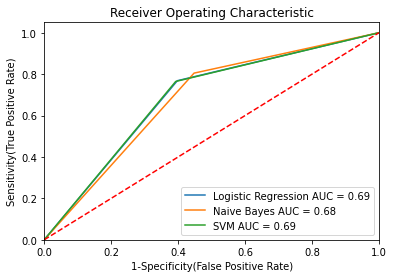

In [46]:
# Plot the ROC curve.
for m in models:
    model = m['model']
    model.fit(X_train, y_train)
    y_pred=model.predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label='%s AUC = %0.2f' % (m['label'], roc_auc))

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('Sensitivity(True Positive Rate)')
plt.xlabel('1-Specificity(False Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

- SVM achieved the best performance.